# Cell Volume, Aneuploidy and Osmotic Stress

This document is created to explore some of the results from Tsai et. al. biophysical model which that derives a relationship between cell volume and ploidy by showing how changes in the *protein abundances* and *composition* in aneuploid cells creates a hypo osmotic stress which causes a change in cell volume. Here we show the main equations of the model and its application to show how cell volume changes as a function of ploidy under different combinations of biophysical parameters of the cell. For the ease of exploration sliders are created for some of the key parameters of the model that can be changed interactively.

## Biophysical model (no ions)

Considering transport of water and by balancing the chemical potential of water inside and outside the cell one gets

$$\mu_{H_2O}^{in} - RT \ln c_{H_2O}^{in} - \int_P^{P + \Pi}V_mdp = \mu_{H_2O}^{out} + \Delta\mu_{H_2O}^{memb} - RT \ln c_{H_2O}^{out}$$

At equilibrium, by equating the chemical potential of water inside and outside one can write

$$\Pi = -\frac{RT}{V_m}\ln{\left(\frac{c_{H_2O}^{in}}{c_{H_2O}^{out}c_{H_2O}^{memb}}\right)} = -\frac{RT}{V_m}\ln{\alpha}$$

In the above equation, $\alpha$ is the water abundance factor.
Considering that water is the dominant component of the cell the effective volume of the cell is then proportional to number of proteins in the cell times the water abundance factor $\alpha$

$$V_{eff} = V - V_m \propto N_p\alpha$$

If there are $N_k$ proteins of type k (where $k = 1,2,\ldots,N$) in the cell and $N_c$ complexes of type c (where $c = 1,2,\ldots,M$ then the total number of free proteins is given by [Tsai 2019][tsai2019hypo]

$$N_p = \sum_{k=1}^{N}N_k - \sum_{c=1}^{M}\min_{k \in S_c}(N_k)N_c$$

Here, the second term considers that the number of complexes of type $c$ is equal to the number of its least abundant component.
This holds if every protein participates in a single complex and every complex assembles fully which are assumed here.
Now if we have aneuploid cells then for particular proteins their amount may double due to duplication of gene coding.
If $A_k$ is the abundance of protein $k$ and $P_k$ is the probability of gene duplication then the number of proteins can be written as $N_k = A_kP_k$. Then the above equatio becomes

$$V_{eff} = V - V_m = \alpha \left(\sum_{k=1}^{N}A_kP_k - \sum_{c=1}^M\min_{k \in S_c}(A_kP_k)N_c\right)$$

To obtain the effective volume one needs estimates of relative abundances of proteins and average sizes of protein complexes. In [Tsai 2019][tsai2019hypo] the relative abundances were obtained from PAX-DB project dataset and average protein complex size was estimated using two methods

- Average number of protein-protein interactions.
- Measurements of number of complex size distributions.

A correction factor was also introduced for protein abundance to account for the correlation of abundances in proteins that form complex. If the correlation factor is $c_{complex}$ then the adjusted abundance is

$$A'_i = A_i(1 - c_{complex}) + c_{complex}\sum_{j\in{complex}}A_j$$


[tsai2019hypo]: #References

## Parameter Sweeps

The simulations were conducted for different sets of parameters. First the important modules were imported. Numpy and matplotlib needs to be installed.

In [1]:
import os, sys
from random import shuffle
import numpy as np
from pickle import load, dump
from combined_simulations import Get_Abundance_Data, core_sim_loop, average_simulation_data
from protein_abundance_preprocess import Ploidy_Data
from protein_abundances import generate_complex_ids, last_complex_adjustment, align_complex_abundances,\
sorted_complex_abundances, complex_distribution, Ion_Contribution
from simulation_plots import Plot_Sweep_Data, Varying_Alpha

### Complex size distribution

The first case we consider is the simplest, where all complexes are present at the same abundance (6). The different parameters of the models are set below

In [2]:
Sweep_Parameters = {
    "complex size" : {
        "sweep_elem" : "total_partners",
        "total_partners" : [6],
        "abundance_correlation" : 0.7,
        "alpha" : 1,
        "ideality_correction" : 1
        }
}

We can initialize some other variables as below

In [3]:
Datadir = "data"
Plotdir = "figures"
Datastatfile = os.path.join(Datadir, "data_stats_dump.dmp")
Interaction = "Paxdb"
abundance_range, total_partners = Get_Abundance_Data(Datastatfile, Interaction = Interaction)

base = np.linspace(0.0, 1.0, 20).tolist()
arr_base = np.array(base) + 1

Then we can create the different cases as below

In [4]:
def sweep_parameter(base, sweep_name, Ions = False, Ion_Alignment = False):
    """
    Performs a sweep over complex sizes
    """
    sweep_key = Sweep_Parameters[sweep_name]["sweep_elem"]
    sweep_values = Sweep_Parameters[sweep_name][sweep_key]
    Data = { key : [] for key in sweep_values }
    Data_Ions = { key : [] for key in sweep_values }
    arr_base = np.array(base) + 1
    Sweepfile = os.path.join("data", "%s.dmp" % sweep_name.capitalize().replace(" ","_"))

    for ii, key in enumerate(sweep_values):

        if Ions:
            Sweep_Parameters[sweep_name][sweep_key] = [key] if sweep_name == "complex size" else key
            complex_contents = generate_complex_ids(Sweep_Parameters[sweep_name]["total_partners"], len(abundance_range))
        else:
            Sweep_Parameters[sweep_name][sweep_key] = key
            complex_contents = generate_complex_ids([Sweep_Parameters[sweep_name]["total_partners"]], len(abundance_range))
        
        complex_contents = last_complex_adjustment(complex_contents, len(abundance_range))
        unaligned_abundances = np.copy(abundance_range)
        aligned_abundances = align_complex_abundances(complex_contents, abundance_range, abundance_correlation = Sweep_Parameters[sweep_name]["abundance_correlation"])
        aligned_abundances = sorted_complex_abundances(aligned_abundances, complex_contents[-1], abundance_range, abundance_correlation = Sweep_Parameters[sweep_name]["abundance_correlation"])
        re_runs, buckets = core_sim_loop(base, complex_contents, aligned_abundances)
        means, stds, pre_buckets = average_simulation_data(re_runs, buckets, alpha = Sweep_Parameters[sweep_name]["alpha"], ideality_correction = Sweep_Parameters[sweep_name]["ideality_correction"])
        Data[key] = (means, stds, pre_buckets)
        ion_contributions = []
        if not Ion_Alignment:
            complex_dist = complex_distribution(complex_contents, unaligned_abundances)
        else:
            complex_dist = complex_distribution(complex_contents, aligned_abundances)
        for aneuploidy_factor in base:
            ion_contributions.append(Ion_Contribution(complex_dist, aneuploidy_factor))

        ion_contributions = np.array(ion_contributions)
        Norm_Factor = (Sweep_Parameters[sweep_name]["alpha"]*Sweep_Parameters[sweep_name]["ideality_correction"])/ion_contributions[0]
        ion_contributions = ion_contributions * Norm_Factor
        Data_Ions[key] = ion_contributions

    
    with open(Sweepfile, "w") as fp: dump({"Sweep_Data" : Data, "arr_base" : arr_base, "Ion_Data" : Data_Ions, "complex_dist" : complex_dist}, fp)

Next we can run the sweep over the complex sizes (in this case there is only one, 6)

In [5]:
sweep_parameter(base, "complex size")

Then we can import the plotting module and get the plots as below

In [6]:
Sweepdatafile = os.path.join(Datadir, "Complex_size.dmp")
from IPython.display import Image, display
from ipywidgets import interactive
import ipywidgets as widgets

f = widgets.IntProgress(min=5, max=50, step=5, value=5)
g = widgets.IntText(value=5, description="Value: ")
display(g)
display(f)

def plot_complex_size(Size=2):
    Sweep_Parameters["complex size"]["total_partners"] = [Size]
    sweep_parameter(base, "complex size")
    Plot_Sweep_Data(Sweepdatafile, "complex size", Ions = False, Alignment = False)
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_complex_size.png'))
    f.value = Size
    g.value = Size

p = interactive(plot_complex_size, Size = widgets.IntSlider(min=5, max=50, step=5, value=5))
p

IntText(value=5, description=u'Value: ')

IntProgress(value=5, max=50, min=5)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT01LCBkZXNjcmlwdGlvbj11J1NpemUnLCBtYXg9NTAsIG1pbj01LCBzdGVwPTUpLCBPdXRwdXQoKSksIF9kb21fY2xhc3Nlcz3igKY=


Setup a progress bar

Next we will change the complex numbers over a range instead of a single value and rerun the simulation again

In [7]:
f1 = widgets.FloatProgress(min=0.5, max=0.9, step=0.1, value=0.7)
f2 = widgets.FloatProgress(min=0.2, max=1.0, step=0.2, value=1.0)
g1 = widgets.FloatText(value=0.7, description="Value: ")
g2 = widgets.FloatText(value=1.0, description="Value: ")
display(g1)
display(f1)
display(g2)
display(f2)

def plot_complex_sweep(abundance_correlation, alpha):
    Sweep_Parameters["complex size"]["total_partners"] = [2, 5, 10, 20, 40]
    Sweep_Parameters["complex size"]["abundance_correlation"] = abundance_correlation
    Sweep_Parameters["complex size"]["alpha"] = alpha
    sweep_parameter(base, "complex size")
    Sweepdatafile = os.path.join(Datadir, "Complex_size.dmp")
    Plot_Sweep_Data(Sweepdatafile, "complex size")
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_complex_size.png'))
    f1.value = abundance_correlation
    g1.value = abundance_correlation
    f2.value = alpha
    g2.value = alpha
    
q = interactive(plot_complex_sweep, 
                abundance_correlation = widgets.FloatSlider(min=0.5, max=0.9, step=0.1, value=0.7),
                alpha = widgets.FloatSlider(min=0.2, max=1.0, step=0.2, value=1.0))
q

FloatText(value=0.7, description=u'Value: ')

FloatProgress(value=0.7, max=0.9, min=0.5)

FloatText(value=1.0, description=u'Value: ')

FloatProgress(value=1.0, max=1.0, min=0.2)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuNywgZGVzY3JpcHRpb249dSdhYnVuZGFuY2VfY29ycmVsYXRpb24nLCBtYXg9MC45LCBtaW49MC41KSwgRmxvYXRTbGnigKY=


### Abundance Correlation Factor

In a similar way we can set the the abundance correlation factor as below

In [8]:
Sweep_Parameters["abundance correlation"] = {
        "sweep_elem" : "abundance_correlation",
        "total_partners" : 2,
        "abundance_correlation" : np.linspace(0.5, 0.9, 5).tolist(),
        "alpha" : 1,
        "ideality_correction" : 1
        }

Now we can run the simulation and plot the results in a similar way

In [9]:
display(g)
display(f)
display(g2)
display(f2)


def plot_abundance_correlation(total_partners, alpha):
    Sweep_Parameters["abundance correlation"]["total_partners"] = total_partners
    Sweep_Parameters["abundance correlation"]["abundance_correlation"] = np.linspace(0.5, 0.9, 5).tolist()
    Sweep_Parameters["abundance correlation"]["alpha"] = alpha
    sweep_parameter(base, "abundance correlation")
    Sweepdatafile = os.path.join(Datadir, "Abundance_correlation.dmp")
    Plot_Sweep_Data(Sweepdatafile, "abundance correlation")
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_abundance_correlation.png'))
    f.value = total_partners
    g.value = total_partners
    f2.value = alpha
    g2.value = alpha
    
r = interactive(plot_abundance_correlation, 
                total_partners = widgets.IntSlider(min=5, max=30, step=5, value=5),
                alpha = widgets.FloatSlider(min=0.2, max=1.0, step=0.2, value=1.0))
r

IntText(value=5, description=u'Value: ')

IntProgress(value=5, max=50, min=5)

FloatText(value=1.0, description=u'Value: ')

FloatProgress(value=1.0, max=1.0, min=0.2)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT01LCBkZXNjcmlwdGlvbj11J3RvdGFsX3BhcnRuZXJzJywgbWF4PTMwLCBtaW49NSwgc3RlcD01KSwgRmxvYXRTbGlkZXIodmHigKY=


### Water abundance factor

Next we can change the water abundance factor and see its effect

In [10]:
Sweep_Parameters["water abundance"] = {
        "sweep_elem" : "alpha",
        "total_partners" : 5,
        "abundance_correlation" : 0.5,
        "alpha" : np.linspace(0.15, 1.0, 6).tolist(),
        "ideality_correction" : 1
        }

In [11]:
display(g)
display(f)
display(g1)
display(f1)

def plot_water_abundance(total_partners, abundance_correlation):
    Sweep_Parameters["water abundance"]["total_partners"] = total_partners
    Sweep_Parameters["water abundance"]["abundance_correlation"] = abundance_correlation
    Sweep_Parameters["water abundance"]["alpha"] = np.linspace(0.15, 1.0, 6).tolist()
    sweep_parameter(base, "water abundance")
    Sweepdatafile = os.path.join(Datadir, "Water_abundance.dmp")
    Plot_Sweep_Data(Sweepdatafile, "water abundance")
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_water_abundance.png'))
    f.value = total_partners
    g.value = total_partners
    f1.value = abundance_correlation
    g1.value = abundance_correlation
    
    
s = interactive(plot_water_abundance, 
                total_partners = widgets.IntSlider(min=5, max=30, step=5, value=5),
                abundance_correlation = widgets.FloatSlider(min=0.5, max=0.9, step=0.1, value=0.7))
s

IntText(value=5, description=u'Value: ')

IntProgress(value=5, max=50, min=5)

FloatText(value=0.7, description=u'Value: ')

FloatProgress(value=0.7, max=0.9, min=0.5)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT01LCBkZXNjcmlwdGlvbj11J3RvdGFsX3BhcnRuZXJzJywgbWF4PTMwLCBtaW49NSwgc3RlcD01KSwgRmxvYXRTbGlkZXIodmHigKY=


### Ideality Correction Factor

Finally we can change the ideality correction factor as below

In [12]:
Sweep_Parameters["ideality correction"] = {
        "sweep_elem" : "ideality_correction",
        "total_partners" : 20,
        "abundance_correlation" : 0.7,
        "alpha" : 1,
        "ideality_correction" : np.linspace(0.5, 1.5, 6).tolist()
        }

In [13]:
display(g)
display(f)
display(g1)
display(f1)
display(g2)
display(f2)

def plot_ideality_correction(total_partners, abundance_correlation, alpha):
    Sweep_Parameters["ideality correction"]["total_partners"] = total_partners
    Sweep_Parameters["ideality correction"]["abundance_correlation"] = abundance_correlation
    Sweep_Parameters["ideality correction"]["alpha"] = alpha
    Sweep_Parameters["ideality correction"]["ideality_correction"] = np.linspace(0.5, 1.5, 6).tolist()
    sweep_parameter(base, "ideality correction")
    Sweepdatafile = os.path.join(Datadir, "Ideality_correction.dmp")
    Plot_Sweep_Data(Sweepdatafile, "ideality correction")
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_ideality_correction.png'))
    f.value = total_partners
    g.value = total_partners
    f1.value = abundance_correlation
    g1.value = abundance_correlation
    f2.value = alpha
    g2.value = alpha
    
t = interactive(plot_ideality_correction, 
                total_partners = widgets.IntSlider(min=5, max=30, step=5, value=5),
                abundance_correlation = widgets.FloatSlider(min=0.5, max=0.9, step=0.1, value=0.7),
                alpha = widgets.FloatSlider(min=0.2, max=1.0, step=0.2, value=1.0))
t

IntText(value=5, description=u'Value: ')

IntProgress(value=5, max=50, min=5)

FloatText(value=0.7, description=u'Value: ')

FloatProgress(value=0.7, max=0.9, min=0.5)

FloatText(value=1.0, description=u'Value: ')

FloatProgress(value=1.0, max=1.0, min=0.2)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT01LCBkZXNjcmlwdGlvbj11J3RvdGFsX3BhcnRuZXJzJywgbWF4PTMwLCBtaW49NSwgc3RlcD01KSwgRmxvYXRTbGlkZXIodmHigKY=


### Varying Water Abundance Factor

Lastly we can run the simulation by varying the water abundance factor $\alpha$ between 0.7 and 1 for different populations and see the effect and whether the results remain bounded.

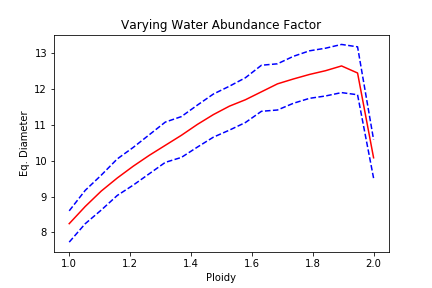

In [14]:
Simdatafile = os.path.join(Datadir, "simulation_data.dmp")
Varying_Alpha(Simdatafile)
display(Image(filename='figures/Varying_Alpha.png'))

## Biophysical Model with Ion Transport

When ions are considered in the solution, transfer of both water and ions are to be considered

### Flux of Water

$$J_w = \alpha(\delta P - \delta \Pi)$$

- $\delta P \rightarrow$  Hydrostatic Pressure
- $\delta \Pi \rightarrow$  Osmotic Pressure
- $\alpha \rightarrow$ Membrane Permeation Constant

At steady state, $J_w = 0$ which gives $\delta P = \delta \Pi$. The hydrostatic pressure difference is given by the Laplace's law for spherical cells in suspension as 

$$P_{in} - P_{out} = \delta P = \frac{2\sigma}{R_{cell}}$$

### Flux of Ions

The ion flux is driven by chemical potential difference and has two contributions

- Across ion channels and *along* potential gradient.
- Across pumps and *against* potential gradient.

Then the net flux of ion i, $j_i$ is given by

$$j_i = -\lambda_i\delta\mu_i + J_i$$

where,

- $\lambda_i \rightarrow$ is the permeability constant
- $\delta\mu_i \rightarrow$ is the chemical potential difference
- $J_i$ is contribution from pumps

At steady state, $j_i = 0$ which gives 

$$\delta\mu_i = \frac{J_i}{\lambda_i}$$

The chemical potential difference is related to concentration of component i inside and outside by 
$$\delta\mu_i = RT\ln{\frac{C_i^{in}}{C_i^{out}}}$$

This means we can write

$$\frac{J_i}{\lambda_i} = RT\ln{\frac{C_i^{in}}{C_i^{out}}}$$

Or absorbing the constant $RT$ in $\lambda_i$ we get

$$\exp\left({\frac{J_i}{\lambda_i}}\right) = {\frac{C_i^{in}}{C_i^{out}}}$$

### Osmotic Pressure

Osmotic Pressure ($\Pi$) can be obtained from Van't Hoff's Law which gives $\Pi = RT\sum_iC_i$ where there are i components in the solution. Suppose the solution has

- $N_i$ ions freely transporting across cell.
- $N_p$ proteins which cannot pass through the membrane.
- $N'_p$ counterions to balance the charge of these proteins.

Then the osmotic pressure difference is given by

$$\delta\Pi = \sum_j RT\delta C_j + RT \frac{\sum_p(N_p + N'_p)}{V_{cell}}$$

Here $\delta C_i = C_i^{in} - C_i{out}$

We can write this as

$$\delta C_i = C_i^{in} - C_i^{out} = C_i^{out}\left(\frac{C_i^{in}}{C_i^{out}} - 1\right)$$

At equilibrium, we have $\delta P = \delta\Pi$ so we can apply the Laplace's equation to get

$$\frac{2\sigma}{R_{cell}} = \sum_j RTC_i^{out}\left(\frac{C_i^{in}}{C_i^{out}} - 1\right) + RT \frac{\sum_p(N_p + N'_p)}{V_{cell}}$$

Putting the value of $\frac{C_i^{in}}{C_i^{out}}$ and neglecting the contribution from Laplace pressure

$$0 = \sum_j RTC_i^{out}\left(\exp\left({\frac{J_i}{\lambda_i}}\right) - 1\right) + RT \frac{\sum_p(N_p + N'_p)}{V_{cell}}$$

Hence the volume of the cell can be written as

$$V_{cell} = \frac{\sum_p(N_p + N'_p)}{\sum_j C_i^{out}\left(\exp\left({\frac{J_i}{\lambda_i}}\right) - 1\right)}$$

Using the expression for $N_p$ as in the biophysical model without ions we get

$$V_{cell} = \frac{\sum_p\left[\left(\sum_{k=1}^{N}A_kP_k - \sum_{c=1}^M\min_{k \in S_c}(A_kP_k)N_c\right] + N'_p\right)}{\sum_j C_i^{out}\left(\exp\left({\frac{J_i}{\lambda_i}}\right) - 1\right)}$$

### Protein Complexes of Size n

Suppose we have $N$ proteins which form complexes of size n or n-mers ($n = 1,2,\ldots$). Each protein monomer releases $m'_p$ counterions whereas the n-mer releases $m_n$ counterions. Here $m_n \geq nm'_p$ at least. Then the total number of species will be give by $N/n + m_nN/n$ or $(m_n + 1)N/n$.

#### Aneuploidy

Now to consider aneuploidy let us consider the probability that a gene is doubled as $p$. Then the following events can happen for N proteins

1. Genes encoding all $n$ proteins that forms a complex are multiplied. The probability (ploidy) is $p^n$.
2. Genes encoding none of the $n$ proteins that forms a complex is multiplied. The probability is $(1 - p)^n$
3. Genes encoding $r$ proteins are doubled where $r = 1,2,3,\ldots,n - 1$. The probability is ${n \choose r} p^r(1 - p)^r$.

Now we make an assumption that in case 3 all proteins stay as monomers. Case 2 is already considered above. Hence the total number of proteins existing as monomer and n-mer is $\frac{N}{n}p^n + N\left(1 - p^n - (1 - p)^n\right)$. Considering the contribution of $m_n$ and $m'_p$ counterions this becomes
$$(m_n + 1)\frac{N}{n}p^n + (m_p + 1)N\left(1 - p^n - (1 - p)^n\right)$$.

Hence if we combine it with the number for euploid case then the volume of the cell becomes

$$V_{cell} = \frac{(m_n + 1)\frac{N}{n}(1 + p^n) + (m_p + 1)N\left(1 - p^n - (1 - p)^n\right)}{\sum_j C_i^{out}\left(\exp\left({\frac{J_i}{\lambda_i}}\right) - 1\right)}$$

This can be written more compactly as

$$V_{cell} = \frac{(m_n + 1)\frac{N}{n}\left((1 + p^n) + n\frac{m_p + 1}{m_n + 1}\left(1 - p^n - (1 - p)^n\right)\right)}{\sum_j C_i^{out}\left(\exp\left({\frac{J_i}{\lambda_i}}\right) - 1\right)}$$

### Special Cases

1. For $p = 0$ we have the case for haploids we get

$$V_{cell}^h = \frac{(m_n + 1)\frac{N}{n}}{\sum_j C_i^{out}\left(\exp\left({\frac{J_i}{\lambda_i}}\right) - 1\right)}$$

2. For $p = 1$ we have $$V_{cell} = 2\frac{(m_n + 1)\frac{N}{n}}{\sum_j C_i^{out}\left(\exp\left({\frac{J_i}{\lambda_i}}\right) - 1\right)} = 2V_{cell}^h$$

3. For $n = 1$ or monomers we have $$V_{cell} = \frac{(m_n + 1)\frac{N}{n}\left(1 + p + \frac{m_p + 1}{m_n + 1}\right)}{\sum_j C_i^{out}\left(\exp\left({\frac{J_i}{\lambda_i}}\right) - 1\right)} = \left(2 + p \right)V_{cell}^h$$

4. For large complexes we can approximate this as $$V_{cell}^{\inf} = \frac{(m'_p + 1)N}{\sum_j C_i^{out}\left(\exp\left({\frac{J_i}{\lambda_i}}\right) - 1\right)} = n\frac{m'_p + 1}{m_n + 1}V_{cell}^h \leq \frac{m'_p + 1}{m'_p}V_{cell}^h$$

## Simulation

To simulate this we adopt the following strategy

1. Find the protein complexes and their abundances from PAX DB and other source.
2. For each complex size $n$ calculate the contribution to the volume using the above formula
3. (Optionally) adjust the abundance using the correlation factor $c_{complex}$.
4. The contribution of the ions is capture in the ratio $\gamma = \frac{m_n + 1}{m'_p + 1}$.

The volume vs. ploidy plot was obtained as below using the above strategy

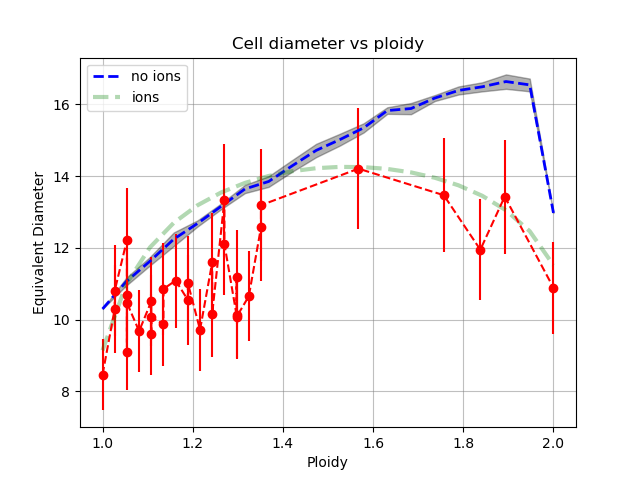

In [15]:
#Unadjusted
display(Image(filename='figures/Cell_Diameter_vs_Ploidy.png'))

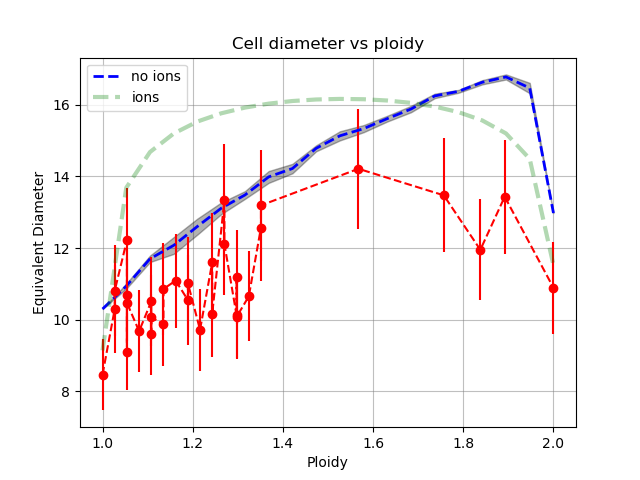

In [16]:
#Adjusted
display(Image(filename='figures/Cell_Diameter_vs_Ploidy_Adjusted.png'))

## Parameter Sweeps

Now we will perform the same series of parameter sweeps as above.

### Complex Sizes

The first parameter of interest is the complex size. The plots are shown below

In [17]:
Sweep_Parameters = {
    "complex size" : {
        "sweep_elem" : "total_partners",
        "total_partners" : [6],
        "abundance_correlation" : 0.7,
        "alpha" : 1,
        "ideality_correction" : 1
        }
}

In [18]:
display(g1)
display(f1)
display(g2)
display(f2)

def plot_complex_sweep(abundance_correlation, alpha):
    Sweep_Parameters["complex size"]["total_partners"] = [2, 5, 10, 20, 40]
    Sweep_Parameters["complex size"]["abundance_correlation"] = abundance_correlation
    Sweep_Parameters["complex size"]["alpha"] = alpha
    sweep_parameter(base, "complex size", Ions = True)
    Sweepdatafile = os.path.join(Datadir, "Complex_size.dmp")
    Plot_Sweep_Data(Sweepdatafile, "complex size", Ions = True)
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_complex_size_Ions.png'))
    Plot_Sweep_Data(Sweepdatafile, "complex size", Ions = True, Alignment = True)
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_complex_size_Ions_Aligned.png'))
    f1.value = abundance_correlation
    g1.value = abundance_correlation
    f2.value = alpha
    g2.value = alpha
    
q = interactive(plot_complex_sweep, 
                abundance_correlation = widgets.FloatSlider(min=0.5, max=0.9, step=0.1, value=0.7),
                alpha = widgets.FloatSlider(min=0.2, max=1.0, step=0.2, value=1.0))
q

FloatText(value=0.7, description=u'Value: ')

FloatProgress(value=0.7, max=0.9, min=0.5)

FloatText(value=1.0, description=u'Value: ')

FloatProgress(value=1.0, max=1.0, min=0.2)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuNywgZGVzY3JpcHRpb249dSdhYnVuZGFuY2VfY29ycmVsYXRpb24nLCBtYXg9MC45LCBtaW49MC41KSwgRmxvYXRTbGnigKY=


### Abundance Correlation

The next parameter we will adjust is with respect to abundance correlation

In [19]:
Sweep_Parameters["abundance correlation"] = {
        "sweep_elem" : "abundance_correlation",
        "total_partners" : 2,
        "abundance_correlation" : np.linspace(0.5, 0.9, 5).tolist(),
        "alpha" : 1,
        "ideality_correction" : 1
        }

In [20]:
f3 = widgets.FloatProgress(min=0.5, max=1.5, step=0.2, value=1.0)
g3 = widgets.FloatText(value=1.0, description="Value: ")

display(g2)
display(f2)
display(g3)
display(f3)

Datadir = "data"
Datastatfile = os.path.join(Datadir, "data_stats_dump.dmp")
Interaction = "Paxdb"
abundance_range, total_partners = Get_Abundance_Data(Datastatfile, Interaction = Interaction)

for key, value in Sweep_Parameters.items():
    if key != "complex size":
        Sweep_Parameters[key]["total_partners"] = total_partners


def plot_abundance_correlation(alpha, ideality_correction):
    Sweep_Parameters["abundance correlation"]["total_partners"] = total_partners
    Sweep_Parameters["abundance correlation"]["abundance_correlation"] = np.linspace(0.5, 0.9, 5).tolist()
    Sweep_Parameters["abundance correlation"]["alpha"] = alpha
    Sweep_Parameters["abundance correlation"]["ideality_correction"] = ideality_correction
    sweep_parameter(base, "abundance correlation", Ions = True)
    Sweepdatafile = os.path.join(Datadir, "Abundance_correlation.dmp")
    Plot_Sweep_Data(Sweepdatafile, "abundance correlation", Ions = True)
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_abundance_correlation_Ions.png'))
    Plot_Sweep_Data(Sweepdatafile, "abundance correlation", Ions = True, Alignment = True)
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_abundance_correlation_Ions_Aligned.png'))
    f3.value = ideality_correction
    g3.value = ideality_correction
    f2.value = alpha
    g2.value = alpha
    
r = interactive(plot_abundance_correlation,
                alpha = widgets.FloatSlider(min=0.2, max=1.0, step=0.2, value=1.0),
                ideality_correction = widgets.FloatSlider(min=0.5, max=1.5, step=0.1, value=1.0))
r

FloatText(value=1.0, description=u'Value: ')

FloatProgress(value=1.0, max=1.0, min=0.2)

FloatText(value=1.0, description=u'Value: ')

FloatProgress(value=1.0, max=1.5, min=0.5)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTEuMCwgZGVzY3JpcHRpb249dSdhbHBoYScsIG1heD0xLjAsIG1pbj0wLjIsIHN0ZXA9MC4yKSwgRmxvYXRTbGlkZXIodmHigKY=


In [21]:
Sweep_Parameters["water abundance"] = {
        "sweep_elem" : "alpha",
        "total_partners" : 5,
        "abundance_correlation" : 0.5,
        "alpha" : np.linspace(0.15, 1.0, 6).tolist(),
        "ideality_correction" : 1
        }

In [22]:
display(g1)
display(f1)
display(g3)
display(f3)

def plot_water_abundance(ideality_correction, abundance_correlation):
    Sweep_Parameters["water abundance"]["total_partners"] = total_partners
    Sweep_Parameters["water abundance"]["abundance_correlation"] = abundance_correlation
    Sweep_Parameters["water abundance"]["alpha"] = np.linspace(0.15, 1.0, 6).tolist()
    sweep_parameter(base, "water abundance", Ions = True)
    Sweepdatafile = os.path.join(Datadir, "Water_abundance.dmp")
    Plot_Sweep_Data(Sweepdatafile, "water abundance", Ions = True)
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_water_abundance_Ions.png'))
    Plot_Sweep_Data(Sweepdatafile, "water abundance", Ions = True, Alignment = True)
    display(Image(filename='figures/Cell_diameter_vs_ploidy_vs_water_abundance_Ions_Aligned.png'))
    f3.value = ideality_correction
    g3.value = ideality_correction
    f1.value = abundance_correlation
    g1.value = abundance_correlation
    
    
s = interactive(plot_water_abundance, 
                ideality_correction = widgets.FloatSlider(min=0.5, max=1.5, step=0.1, value=1.0),
                abundance_correlation = widgets.FloatSlider(min=0.5, max=0.9, step=0.1, value=0.7))
s

FloatText(value=0.7, description=u'Value: ')

FloatProgress(value=0.7, max=0.9, min=0.5)

FloatText(value=1.0, description=u'Value: ')

FloatProgress(value=1.0, max=1.5, min=0.5)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTEuMCwgZGVzY3JpcHRpb249dSdpZGVhbGl0eV9jb3JyZWN0aW9uJywgbWF4PTEuNSwgbWluPTAuNSksIEZsb2F0U2xpZGXigKY=


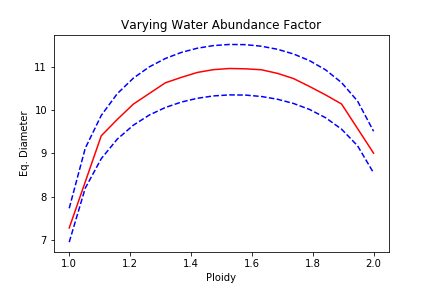

In [23]:
Simdatafile = os.path.join(Datadir, "simulation_data.dmp")
Varying_Alpha(Simdatafile, Ions = True)
display(Image(filename='figures/Varying_Alpha_Ions.png'))

## References
 
1. Hung-Ji Tsai, Anjali R Nelliat, Mohammad Ikbal Choudhury, Andrei Kuchar-
avy, William D Bradford, Malcolm E Cook, Jisoo Kim, Devin B Mair, Sean X
Sun, Michael C Schatz, and Rong Li. Hypo-osmotic-like stress underlies general
cellular defects of aneuploidy. Nature, 570(7759):117–121, 2019.